In [1]:
import os
import sys
os.chdir('/home/msun415/induction/')
import pickle
from src.config import METHOD, DATASET, GRAMMAR
import importlib
from src.examples import *
from src.draw.color import to_hex, CMAP
from src.draw.graph import draw_graph
from src.config import RADIUS
from argparse import ArgumentParser
import pickle
from src.grammar.common import get_args
from src.grammar.ednce import *
from src.draw.graph import *
from src.api.get_motifs import *
from src.algo.utils import *
from src.algo.common import *
from src.grammar.common import *
from src.grammar.utils import *
from src.algo.ednce import terminate, dfs
from src.model import graph_regression, transformer_regression
from argparse import ArgumentParser
from networkx.algorithms.isomorphism import DiGraphMatcher
import pdb

/home/msun415/miniconda3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(args):
    if DATASET == "cora":
        g = load_cora()
    elif DATASET == "test":
        g = create_test_graph(1)
    elif DATASET == "debug":
        g = debug()
    elif DATASET == "house":
        g = create_house_graph()
    elif DATASET == "ckt":
        g = load_ckt(50)
    elif DATASET == "mol":
        g = read_file(
            f"data/api_mol_hg/{args.dataset}_smiles.txt"
        )
    else:
        raise NotImplementedError
    return g
    
def get_args():
    parser = ArgumentParser()
    # global args
    parser.add_argument("--visualize", dest="global_visualize", action='store_true')
    parser.add_argument("--cache", dest="global_cache", action='store_true')    
    parser.add_argument("--num_threads", dest="global_num_threads", type=int)
    parser.add_argument("--num_procs", dest="global_num_procs", type=int)    
    # hparams
    parser.add_argument("--scheme", choices=['one','zero'], help='whether to index from 0 or 1', default='zero')
    # ablations
    parser.add_argument("--ablate_tree", action='store_true') 
    parser.add_argument("--ablate_merge", action='store_true') 
    parser.add_argument("--ablate_root", action='store_true') 
    # task params
    parser.add_argument("--task", nargs='+', choices=["learn","generate","prediction"])
    parser.add_argument("--seed")
    parser.add_argument("--grammar_ckpt")
    parser.add_argument(
        "--dataset",
        choices=["ptc","hopv","polymers_117", "isocyanates", "chain_extenders", "acrylates"],
    )
    parser.add_argument("--num_samples", default=10000, type=int)
    return parser.parse_args([
        '--task', 'learn'
    ])

In [3]:
args = get_args()
g = load_data(args)
cache_iter, cache_path = setup()
g, grammar, anno, iter = init_grammar(g, cache_iter, cache_path, EDNCEGrammar)
grammar, model, anno, g = terminate(g, grammar, anno, iter)
for j, m in enumerate(model):
    pre = get_prefix(m.id)
    # draw_tree(m, os.path.join(IMG_DIR, f"model_{iter}_{pre}.png"))
    model[j] = EDNCEModel(dfs(anno, m.id))

100%|██████████| 50/50 [00:00<00:00, 3553.89it/s]


In [4]:
[model[0].graph[n].attrs['rule'] for n in model[0].seq]

[21, 49]

In [5]:
graphs = []
for j in range(50):
    deriv = model[j].seq[::-1]
    deriv = [model[j].graph[n].attrs['rule'] for n in deriv]
    t2r = {i:i for i in range(len(grammar.rules))}
    deriv_g = grammar.derive(deriv, t2r)
    # draw_graph(deriv_g, '/home/msun415/test.png')
    graphs.append(deriv_g)

In [6]:
def find_indices(graphs, query):
    ans = []
    for i in range(len(graphs)):
        if nx.is_isomorphic(graphs[i], query):
            ans.append(i)
    return ans


def node_match(d1, d2):
    return d1.get("label", "#") == d2.get("label", "#")    


def find_partial(graphs, query):
    ans = []
    # query can be a (possibly disconnected) directed graph
    # query_und = nx.Graph(query)
    for i in range(len(graphs)):
        bad = False
        if len(query) > len(graphs[i]):
            continue
        if len(query.edges) > len(graphs[i].edges):
            continue
        # for conn in nx.connected_components(query_und):
            # conn_g = copy_graph(query, conn)
        gm = DiGraphMatcher(graphs[i], query, node_match=node_match)
        ism_iter = list(gm.subgraph_isomorphisms_iter())
        if len(ism_iter) == 0:
            break
        if not bad:
            ans.append(i)
    return ans


def worker(shared_queue, found, lock):
    while True:
        with lock:
            if shared_queue.empty():
                print("process done")
                break
            print(f"len(interms): {shared_queue.qsize()}")
            interm, deriv, poss = shared_queue.get()
        print(f"deriv: {deriv}")
        nts = grammar.search_nts(interm, NONTERMS)
        if len(nts) == 0:
            if nx.is_isomorphic(interm, graphs[poss], node_match=node_match):
                with lock:
                    found[poss].append(deriv)
                    print(f"found {deriv} graph {poss}, count: {len(found[poss])}")
        for j, nt in enumerate(nts):
            for i, rule in enumerate(grammar.rules):                      
                nt_label = interm.nodes[nt]['label']
                if rule.nt == nt_label:
                    c = deepcopy(interm)
                    c = rule(c, nt)
                    if nx.is_connected(nx.Graph(c)):
                        # if poss == 0 and i == 62:
                        #     pdb.set_trace()                     
                        ts = [x for x in c if c.nodes[x]['label'] in TERMS]
                        c_t = copy_graph(c, ts)
                        exist = find_partial([graphs[poss]], c_t)
                        if exist:
                            with lock:
                                shared_queue.put((c, deriv+[i], poss))            


NUM_PROCS = 50
N = len(graphs)
manager = mp.Manager()
shared_queue = manager.Queue()
found = manager.list()
g = nx.DiGraph()
g.add_node('0', label='black')
for j in range(NUM_PROCS):
    shared_queue.put((deepcopy(g), [], j))
    found.append(manager.list())
lock = manager.Lock()
processes = []
for _ in range(NUM_PROCS):
    p = mp.Process(target=worker, args=(shared_queue, found, lock))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

len(interms): 50
deriv: []
len(interms): 49
deriv: []
len(interms): 49
deriv: []
len(interms): 49
deriv: []
len(interms): 52
deriv: []
len(interms): 55
deriv: []len(interms): 54

deriv: []
len(interms): 55
deriv: []
len(interms): 54
deriv: []
len(interms): 54
deriv: []
len(interms): 56
deriv: []
len(interms): 56
deriv: []
len(interms): 56
deriv: []
len(interms): 56
deriv: []len(interms): 59

deriv: []len(interms): 60

deriv: []
len(interms): 62
deriv: []len(interms): 63

deriv: []
len(interms): 62
deriv: []
len(interms): 64
deriv: []
len(interms): 66
deriv: []
len(interms): 71
deriv: []
len(interms): 73
deriv: []len(interms): 75

deriv: []
len(interms): 78
deriv: []len(interms): 81

deriv: []
len(interms): 86
deriv: []len(interms): 88

deriv: []
len(interms): 93
deriv: []

len(interms): 95deriv: []
len(interms): 96
deriv: []
len(interms): 99
deriv: []len(interms): 98

deriv: []len(interms): 97

deriv: []len(interms): 102

deriv: []len(interms): 105

deriv: []
len(interms): 105
deriv: [

In [7]:
all_derivs = list(map(list, found))
sets_of_sets = []
for derivs in all_derivs:
    sets = []
    for i in range(len(derivs)):
        # keep this deriv
        for j in range(len(derivs)):
            if j == i:
                continue
            sets.append(set(derivs[j])-set(derivs[i]))
    sets_of_sets.append(sets)

In [8]:
np.argwhere([len(deriv) > 1 for deriv in all_derivs])
# [len(deriv) > 1 for deriv in all_derivs]
poss_elims = []
for chosen in product(*[sets for sets in sets_of_sets if sets]):
    elim = set.union(*chosen)
    exist = False
    for p in poss_elims:
        if p == elim:
            exist = True
            break
    if not exist:
        poss_elims.append(elim)

poss_elims = sorted(poss_elims, key=len)
for i in range(len(poss_elims)):
    if poss_elims[i] is None:
        continue
    for j in range(i+1, len(poss_elims)):
        if poss_elims[j] is None:
            continue
        if not (poss_elims[i]-poss_elims[j]):
            poss_elims[j] = None

min_poss_elims = list(filter(lambda x: x is not None, poss_elims))
best_e = None
best_counter = None
for e in min_poss_elims:
    counter = []
    for i, derivs in enumerate(all_derivs):
        inters = [bool(set(derivs[j]) & e) for j in range(len(derivs))]
        if np.all(inters):
            counter.append(i)
    if best_counter is None or len(counter) < len(best_counter):
        best_counter = counter
        best_e = e



TypeError: descriptor 'union' of 'set' object needs an argument

In [ ]:
rmap = {}
d = 0
for i in range(len(grammar.rules)):
    if i in best_e:
        d += 1
        continue
    rmap[i] = i-d

for i in range(len(model)-1,-1,-1):
    if i in best_counter:
        model.pop(i)
        continue
    for n in model[i].graph:
        r = model[i].graph[n].attrs['rule']
        model[i].graph[n].attrs['rule'] = rmap[r]



{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61}

In [2]:
Path('/home/msun415/induction/data/api_ckt_ednce/stuff.txt').stem

'stuff'

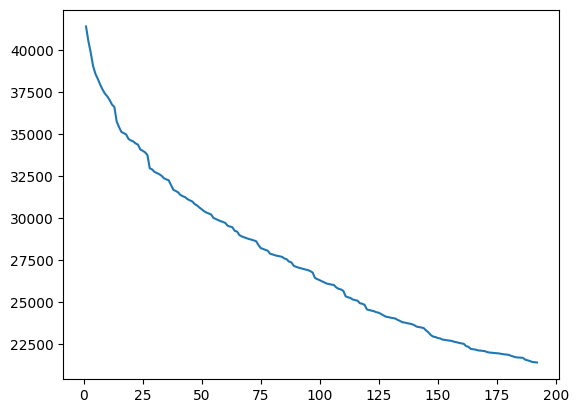

In [25]:
%matplotlib inline
lines = open('/home/msun415/induction/data/api_ckt_ednce.log').readlines()
occurs = re.findall('graph at iter (\d+) has (\d+) nodes', '\n'.join(lines))
index = [i for i in range(len(occurs)) if occurs[i][0] == '1'][-1]
fig, ax = plt.subplots()
ax.plot([int(i) for i, _ in occurs[index:]], [int(num) for _, num in occurs[index:]])
